Household Electricity Consumption Usage Time Series Analysis
---

Author - Ibidokun


---

The data looks contains measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years; the data is initially untidy, and will take a lot of cleaning. 

We will conduct the time series analysis, correlation between the data and then construct an Autoregressive Model to predict future values. Also, building ARIMA and SARIMA model in this notebook.

### Data Description

The dataset is multivariate time series and was collected between December 2006 and November 2010 and observations were collected every minute containing  seven variables (besides the date and time) which are the following:

- global_active_power: The total active power consumed by the household (kilowatts).
- global_reactive_power: The total reactive power consumed by the household (kilowatts).
- voltage: Average voltage (volts).
- global_intensity: Average current intensity (amps).
- sub_metering_1: Active energy for kitchen (watt-hours of active energy).
- sub_metering_2: Active energy for laundry (watt-hours of active energy).
- sub_metering_3: Active energy for climate control systems (watt-hours of active energy).

Active and reactive energy refer to the technical details of alternative current.

In [32]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 


from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import train_test_split
import numpy as np
import datetime

sns.set_style('darkgrid')
%matplotlib inline

import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import missingno as msno

In [33]:
df = pd.read_csv('/Users/carolynesalcido/Downloads/household_power_consumption.txt', sep=';', parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [34]:
## Changing the data types to correct format
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'])
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'])
df['Voltage'] = pd.to_numeric(df['Voltage'])
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'])
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'])
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'])
from numpy import nan

df.replace('?', nan, inplace=True)

In [35]:
for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7)
memory usage: 126.7 MB


In [37]:
df.shape

(2075259, 7)

In [38]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


## Visualizing time series

#### Average consumption of each day in 4 years

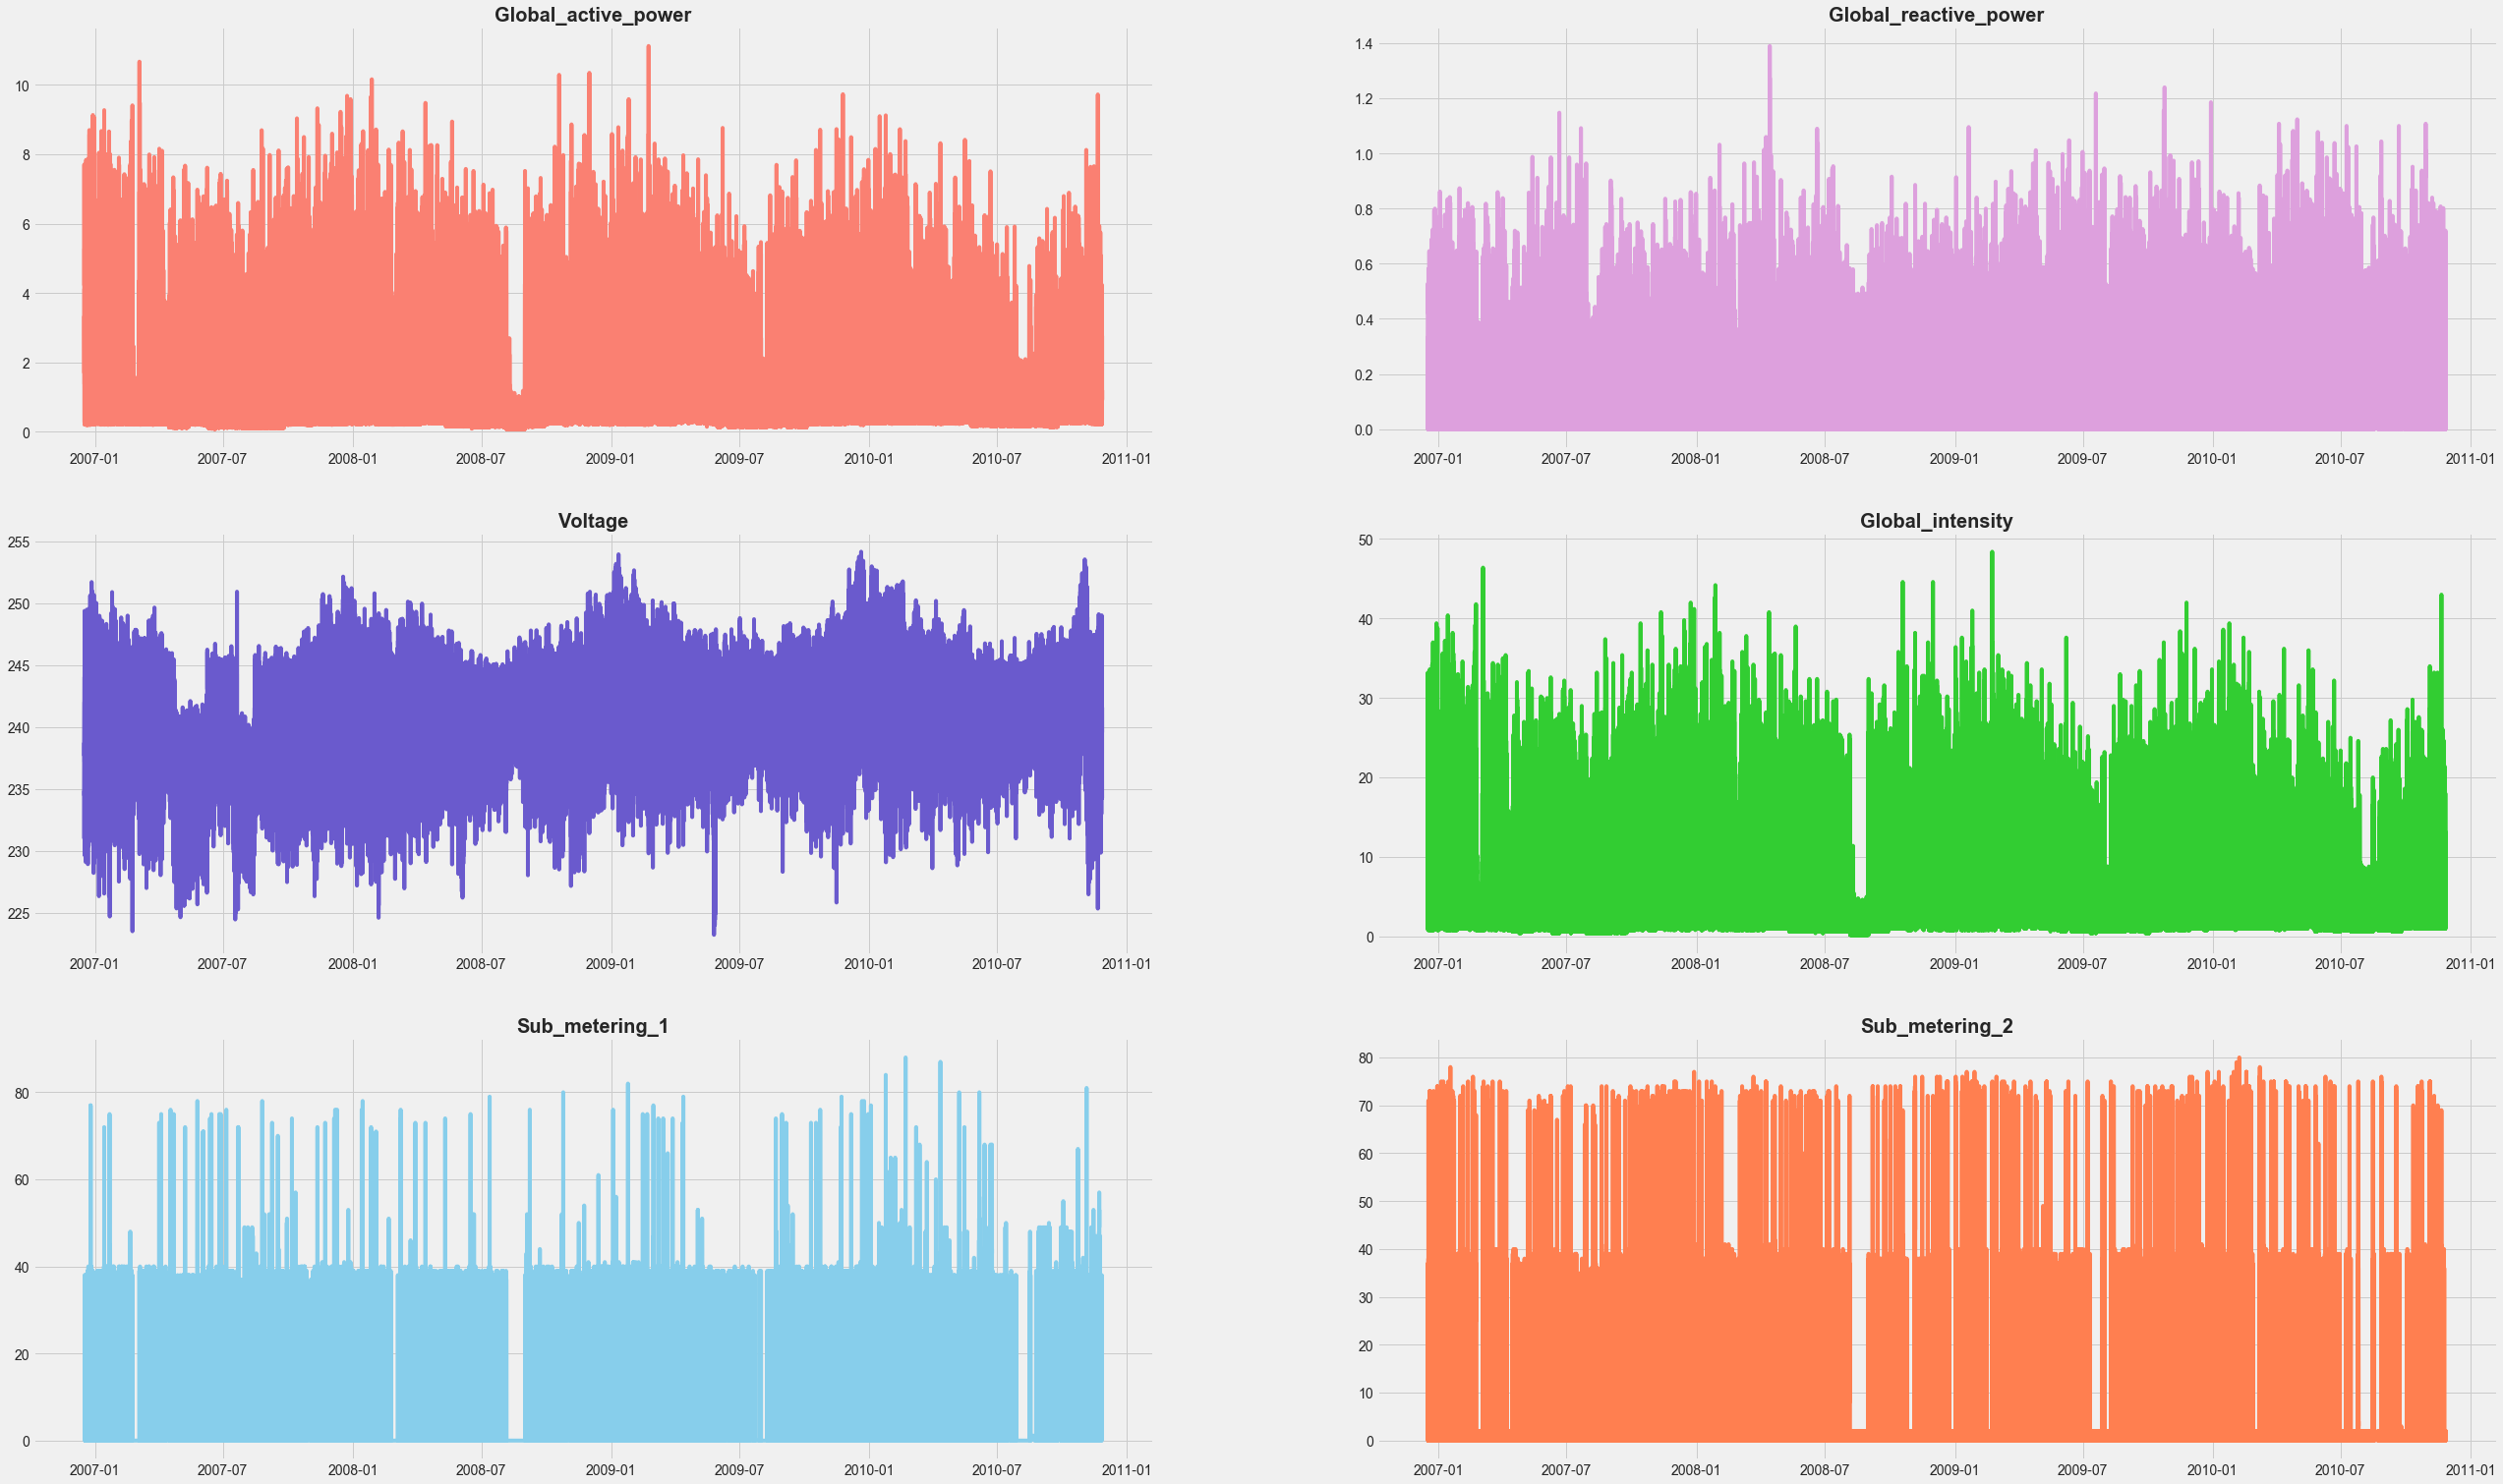

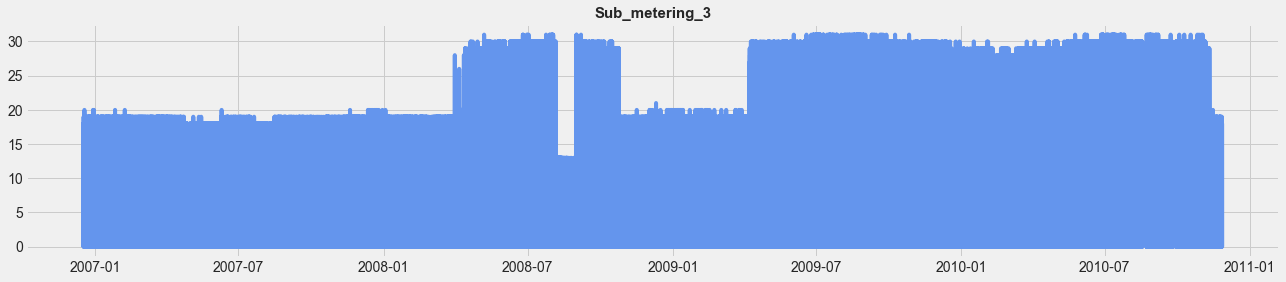

In [39]:
colors = ['cornflowerblue','salmon', 'plum','slateblue','limegreen','skyblue','coral']

mean_consumption_gby_date = df.groupby(['dt']).mean()
columns = mean_consumption_gby_date.columns

plt.style.use('fivethirtyeight')

mean_consumption_gby_date = df.groupby(['dt']).mean()
fig, axs = plt.subplots(3, 2, figsize = (40, 25))
columns = mean_consumption_gby_date.columns
axs[0, 0].plot(mean_consumption_gby_date[columns[0]], color = colors[1])
axs[0, 0].set_title(columns[0], fontweight = 'bold', size = 20)

axs[0, 1].plot(mean_consumption_gby_date[columns[1]], color = colors[2])
axs[0, 1].set_title(columns[1], fontweight = 'bold', size = 20)

axs[1, 0].plot(mean_consumption_gby_date[columns[2]], color = colors[3])
axs[1, 0].set_title(columns[2], fontweight = 'bold', size = 20)

axs[1, 1].plot(mean_consumption_gby_date[columns[3]], color = colors[4])
axs[1, 1].set_title(columns[3], fontweight = 'bold', size = 20)

axs[2, 0].plot(mean_consumption_gby_date[columns[4]], color = colors[5])
axs[2, 0].set_title(columns[4], fontweight = 'bold', size = 20)

axs[2, 1].plot(mean_consumption_gby_date[columns[5]], color = colors[6])
axs[2, 1].set_title(columns[5], fontweight = 'bold', size = 20)

fig, axs = plt.subplots( figsize = (20, 4))
axs.plot(mean_consumption_gby_date[columns[6]], color = colors[0])
axs.set_title(columns[6], fontweight = 'bold', size = 15)
plt.show()

#### Average consumption of each month in 4 years

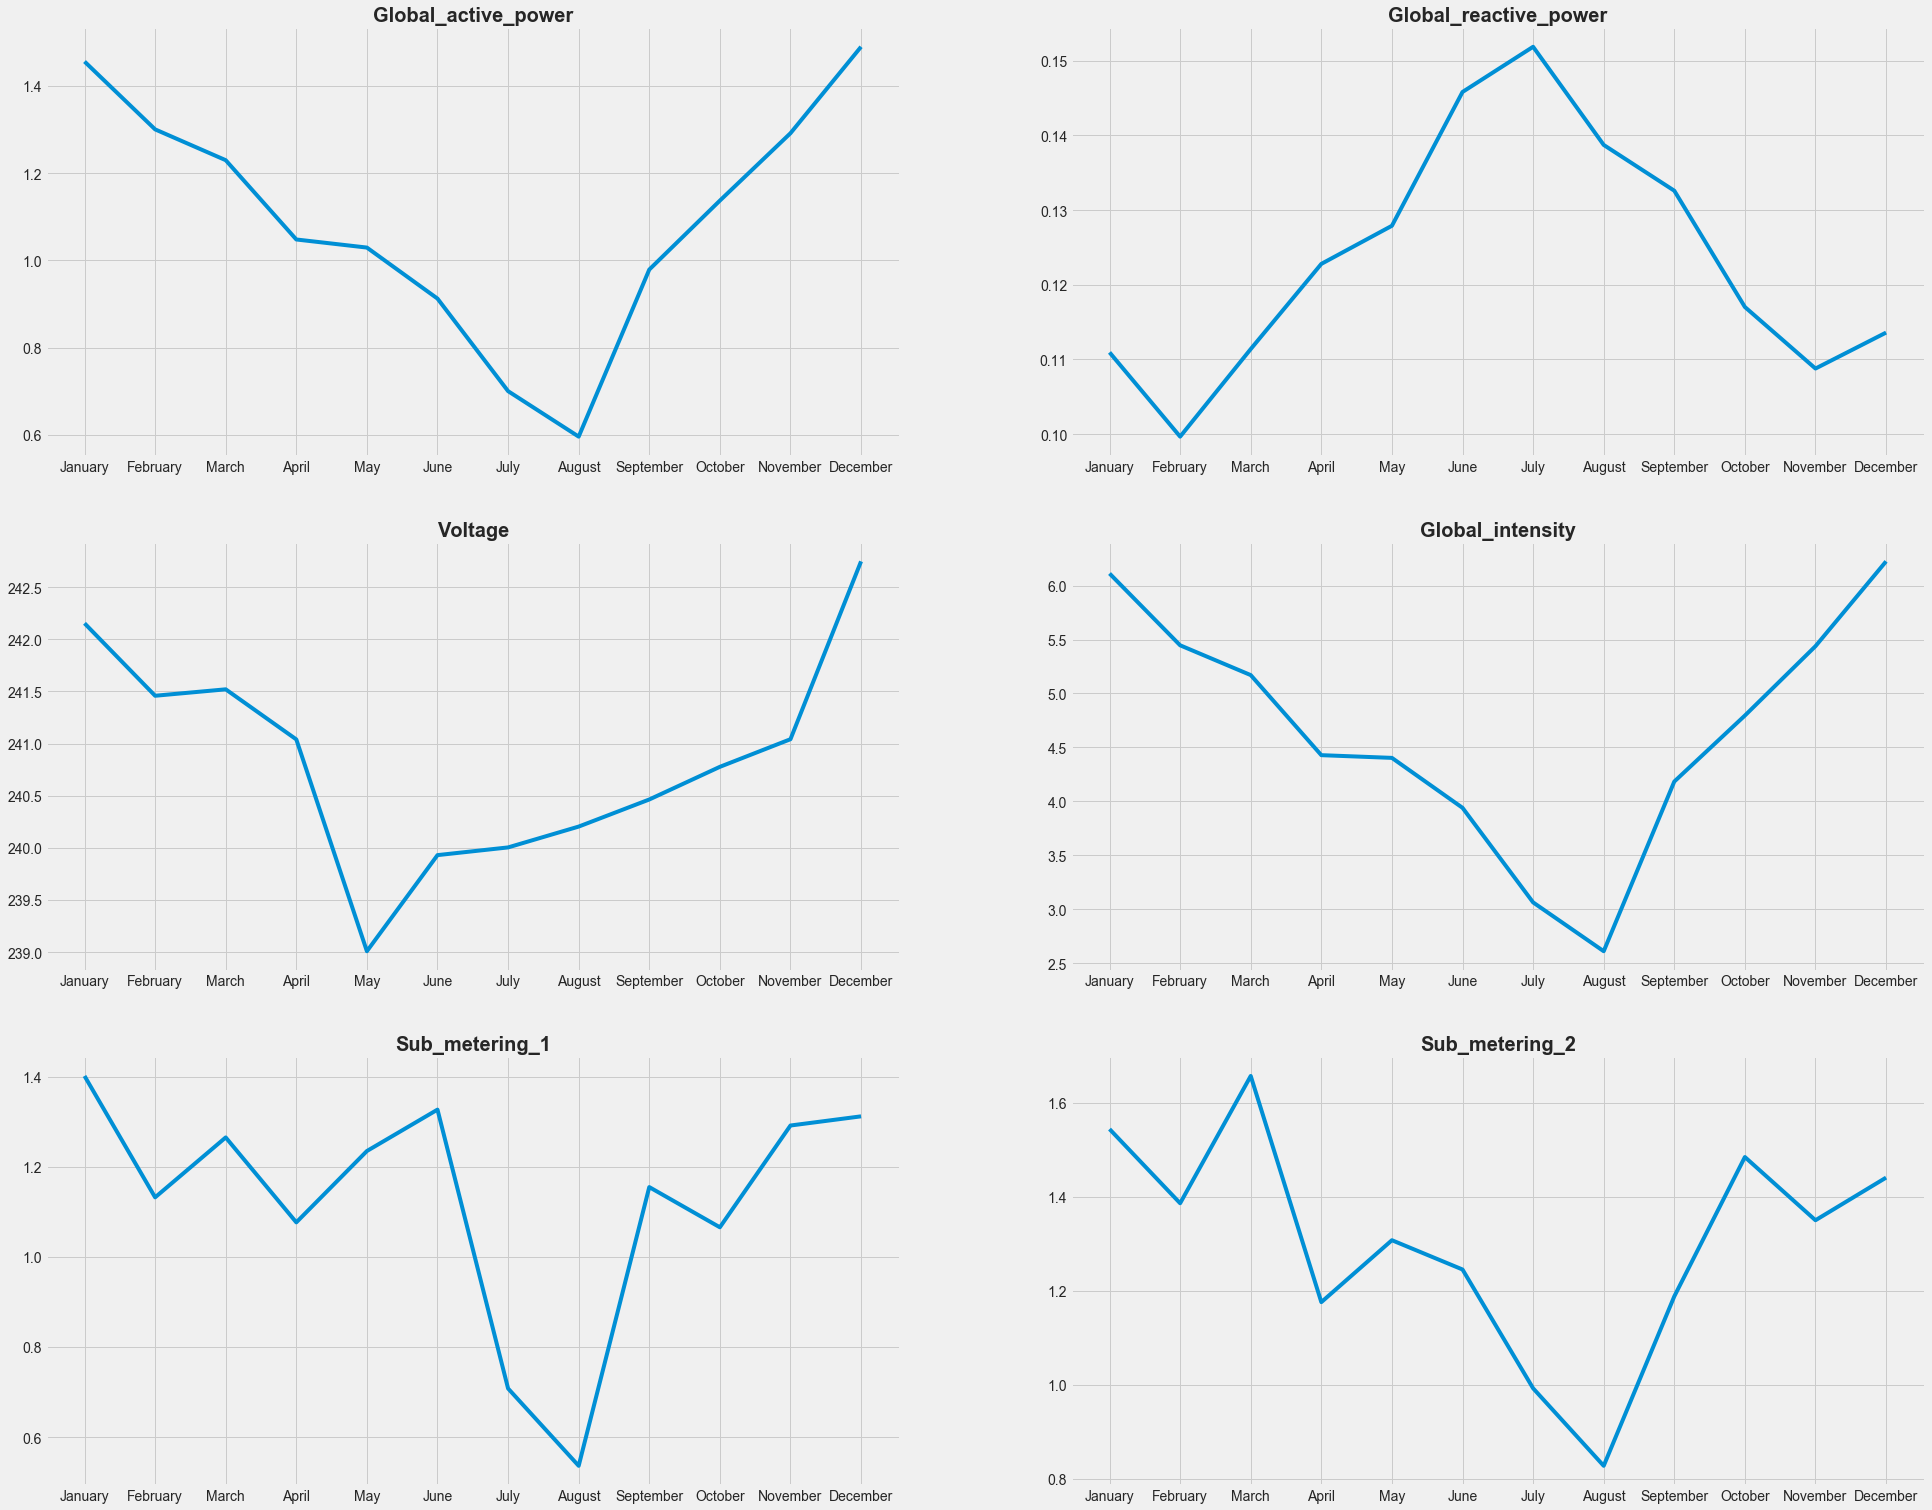

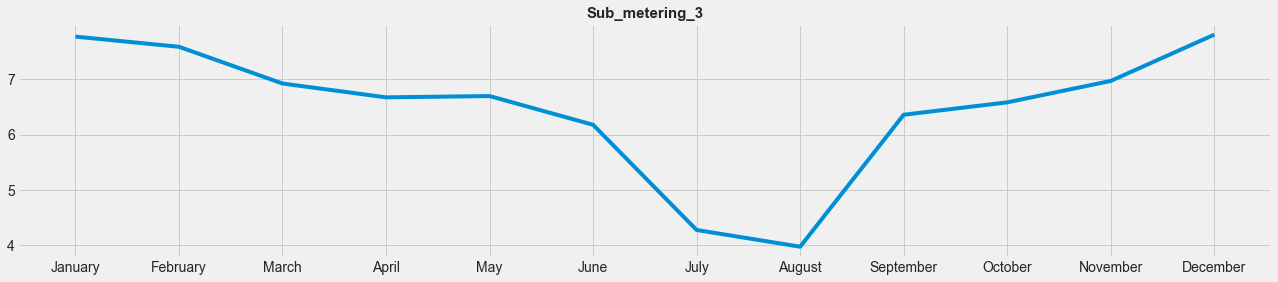

In [40]:
mean_consumption_gby_month = df.reset_index().groupby(df.reset_index()['dt'].dt.strftime('%B')).mean()
reorderlist = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December' ]
mean_consumption_gby_month = mean_consumption_gby_month.reindex(reorderlist)

fig, axs = plt.subplots(3, 2, figsize = (30, 25))
columns = mean_consumption_gby_month.columns

axs[0, 0].plot(mean_consumption_gby_month[columns[0]])
axs[0, 0].set_title(columns[0], fontweight = 'bold', size = 20)

axs[0, 1].plot(mean_consumption_gby_month[columns[1]])
axs[0, 1].set_title(columns[1], fontweight = 'bold', size = 20)

axs[1, 0].plot(mean_consumption_gby_month[columns[2]])
axs[1, 0].set_title(columns[2], fontweight = 'bold', size = 20)

axs[1, 1].plot(mean_consumption_gby_month[columns[3]])
axs[1, 1].set_title(columns[3], fontweight = 'bold', size = 20)


axs[2, 0].plot(mean_consumption_gby_month[columns[4]])
axs[2, 0].set_title(columns[4], fontweight = 'bold', size = 20)

axs[2, 1].plot(mean_consumption_gby_month[columns[5]])
axs[2, 1].set_title(columns[5], fontweight = 'bold', size = 20)

fig, axs = plt.subplots( figsize = (20, 4))
axs.plot(mean_consumption_gby_month[columns[6]])
axs.set_title(columns[6], fontweight = 'bold', size = 15)
plt.show()

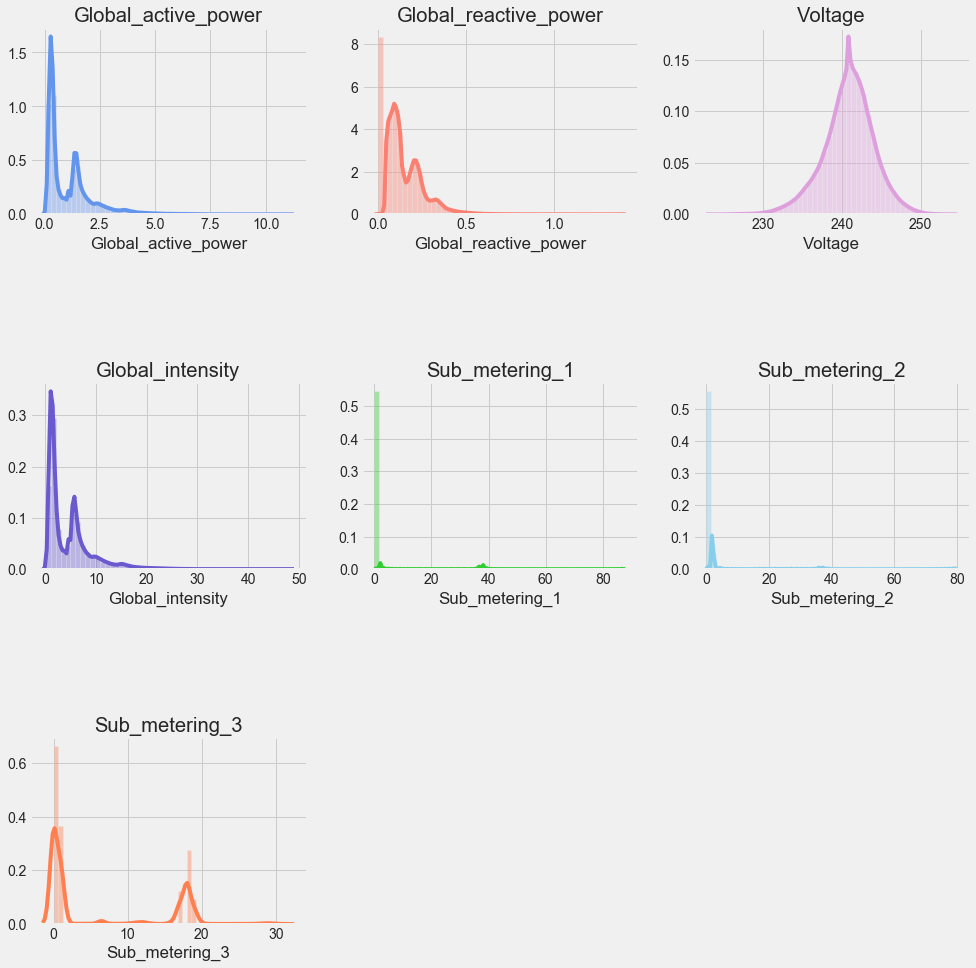

In [41]:
plt.figure(figsize=(15,15))
plt.title("Distribution of each feature")
for feature in df:
    # Get index of the feature in the dataset 
    idx_col = df.columns.get_loc(str(feature))
    plt.subplot(3,3,idx_col+1)
    plt.title(str(feature))
    sns.distplot(df[str(feature)], color=colors[idx_col])
plt.subplots_adjust(top=0.9,hspace=0.9)

### Power Consumption summed across the day.

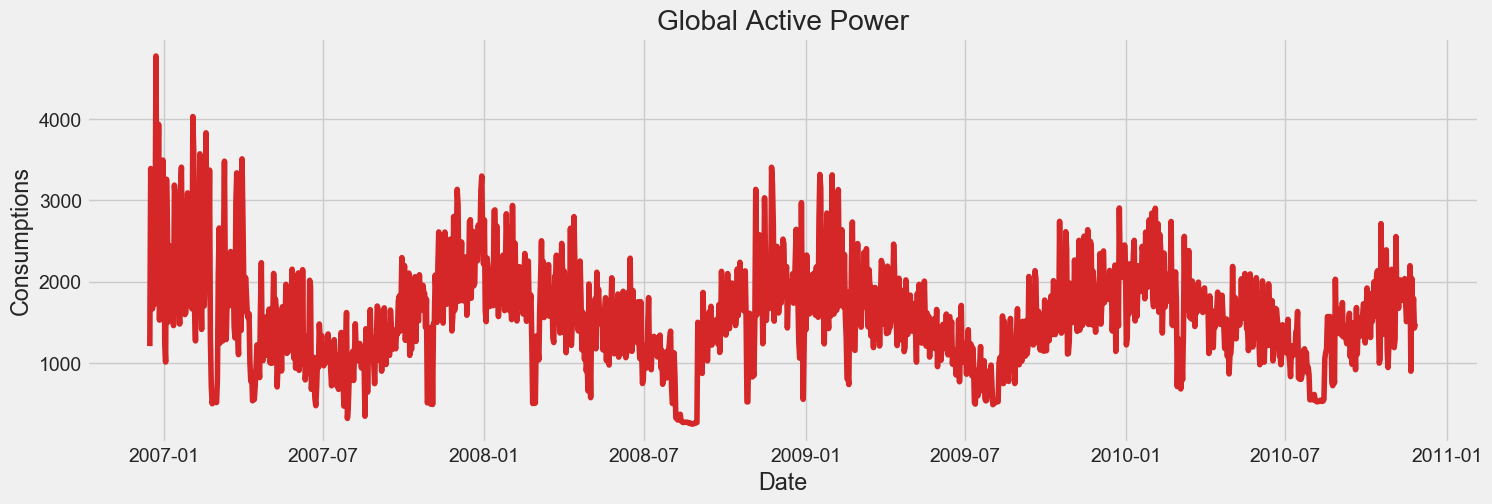

In [42]:
pwr_consumption = df.reset_index()[['dt', 'Global_active_power', 'Global_reactive_power']]
pwr_consumption['Date'] = pwr_consumption['dt'].dt.date
pwr_consumption.drop(['dt'], axis=1, inplace = True)
pwr_consumption = pwr_consumption.groupby('Date').sum()
def plot_df(df, x, y, title="qu'est-ce ?", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_df(pwr_consumption, x=pwr_consumption.index, y=pwr_consumption[['Global_active_power']],title='Global Active Power',ylabel='Consumptions')

Note that it is possible that we have an annual periodicity.

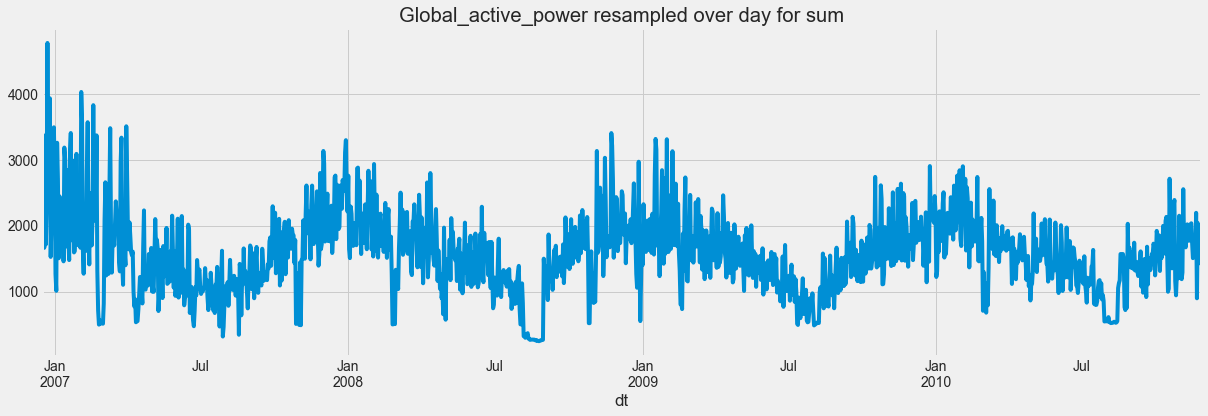

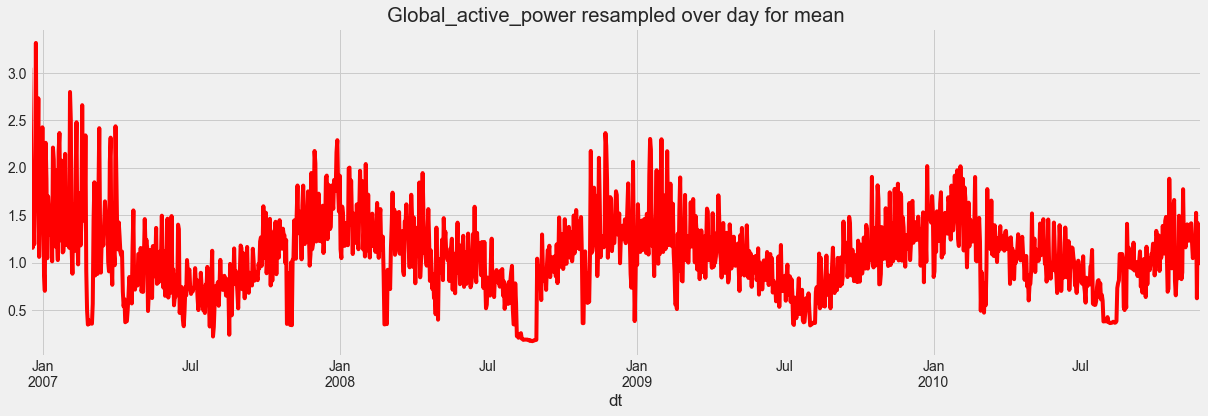

In [43]:
plt.figure(figsize=(17,6))
df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum') 
plt.tight_layout()
plt.show()   

plt.figure(figsize=(17,6))
df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean', color='red') 
plt.tight_layout()
plt.show()

In [44]:
consumption_weekly = df.Global_active_power.resample('W').sum()
consumption_mothly = df.Global_active_power.resample('M').sum()

In [45]:
df = df.reset_index()
df['year'] = df['dt'].dt.year
df['month'] = df['dt'].dt.month
df['day'] = df['dt'].dt.dayofyear
df['weekday'] = df['dt'].dt.weekday 

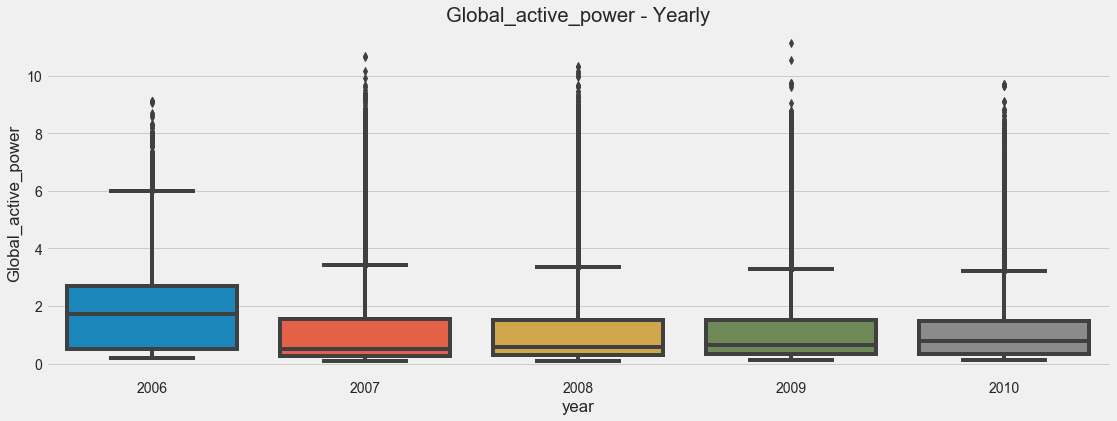

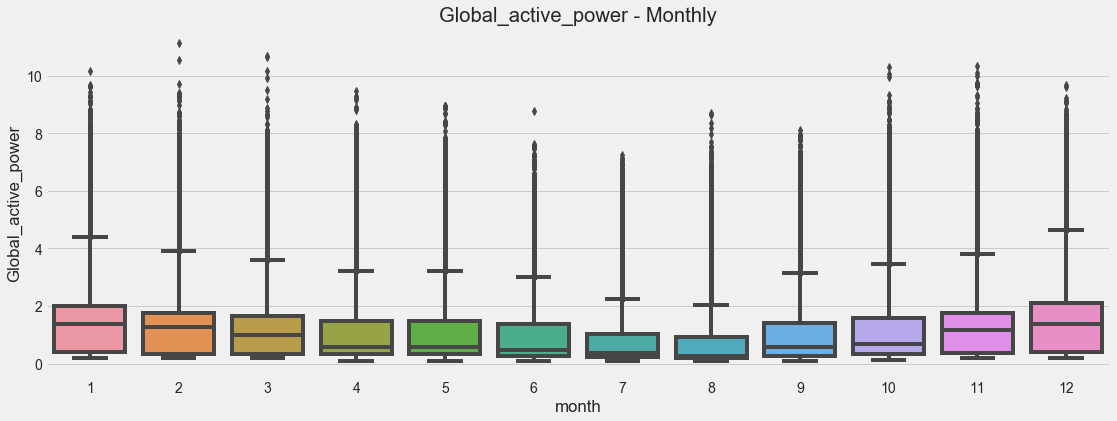

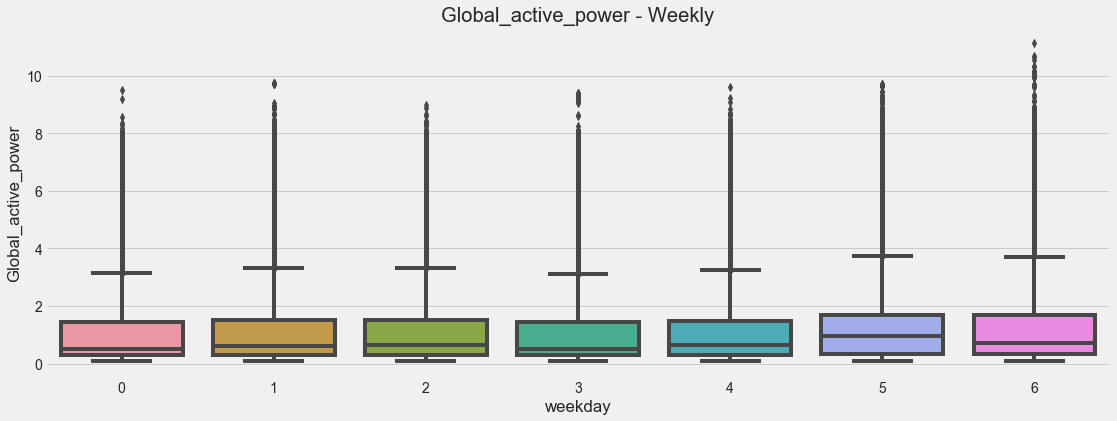

In [46]:
plt.figure(figsize=(17,6))
sns.boxplot(x = "year", y = "Global_active_power" , data = df)
plt.title('Global_active_power - Yearly')
plt.show()

plt.figure(figsize=(17,6))
sns.boxplot(x = "month", y = "Global_active_power" , data = df)
plt.title('Global_active_power - Monthly')
plt.show()

plt.figure(figsize=(17,6))
sns.boxplot(x = "weekday", y = "Global_active_power" , data = df)
plt.title('Global_active_power - Weekly')
plt.show()

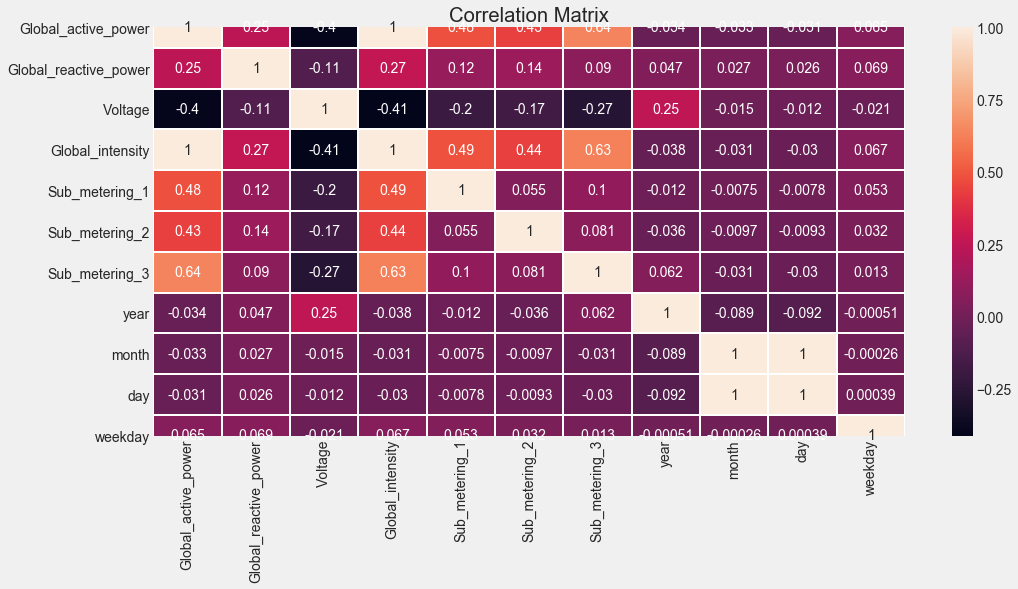

In [47]:
plt.figure(figsize=(15,7))
plt.title('Correlation Matrix')
sns.heatmap(df.corr(), annot=True, linewidths=1)
plt.show()

There are no high positive or negative correlations in the variables.

### Lag Plot

Lag plots are most commonly used to look for patterns in time series data. Lag plots can provide answers to the following questions:
- Are the data random?
- Is there serial correlation in the data?
- What is a suitable model for the data?
- Are there outliers in the data?


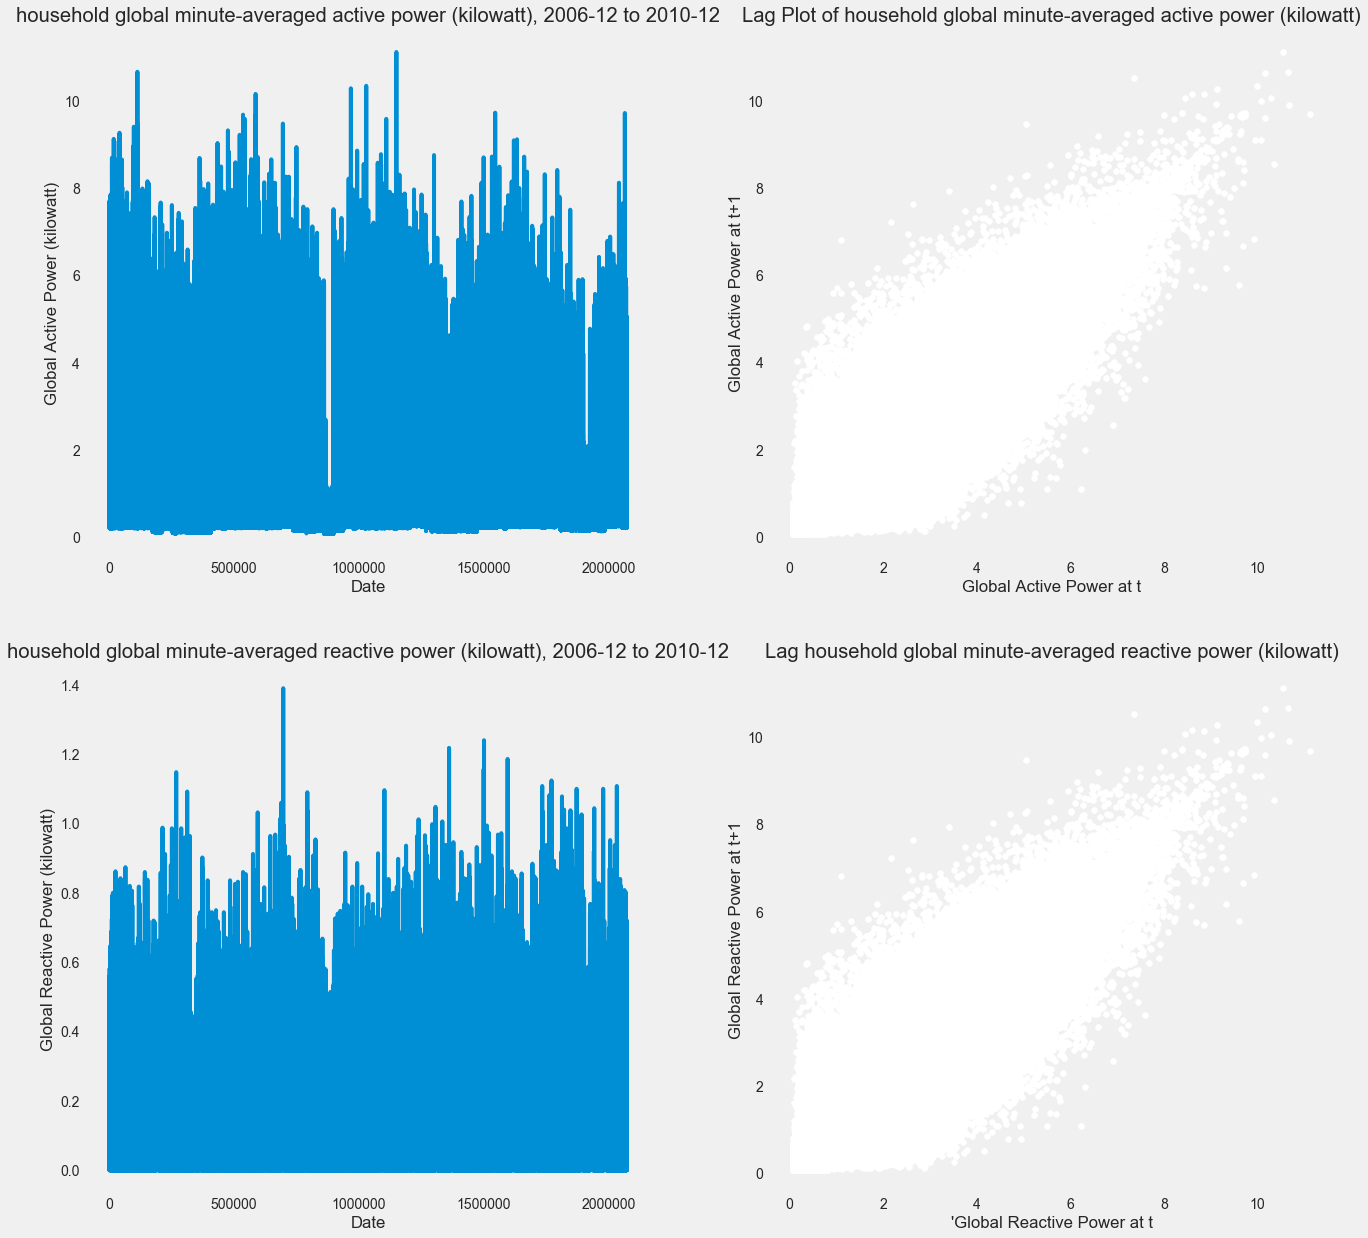

In [48]:
glb_active_pwr   = df['Global_active_power']
glb_reactive_pwr = df['Global_reactive_power'] 

def time_series_plotting(func, series1, series2):
    fig = plt.figure(figsize=(20,20))    
    ax1 = fig.add_subplot(221)
    ax1.plot(series1) 
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Global Active Power (kilowatt)")
    ax1.grid(False)
    ax1.set_title('household global minute-averaged active power (kilowatt), 2006-12 to 2010-12')
    
    ax2 = fig.add_subplot(222) 
    func(series1,ax=ax2, c = 'white')
    ax2.set_xlabel("Global Active Power at t")
    ax2.set_ylabel("Global Active Power at t+1") 
    ax2.grid(False)
    ax2.set_title('Lag Plot of household global minute-averaged active power (kilowatt)')   
    
    ax3 = fig.add_subplot(223)
    ax3.plot(series2) 
    ax3.set_xlabel("Date") 
    ax3.set_ylabel("Global Reactive Power (kilowatt)") 
    ax3.grid(False)
    ax3.set_title('household global minute-averaged reactive power (kilowatt), 2006-12 to 2010-12')
    
    ax4 = fig.add_subplot(224)
    func(series1,ax=ax4, c = 'white')
    ax4.set_xlabel("'Global Reactive Power at t")
    ax4.set_ylabel("Global Reactive Power at t+1") 
    ax4.grid(False)
    ax4.set_title('Lag household global minute-averaged reactive power (kilowatt)')  
    
    plt.show()

time_series_plotting(lag_plot, glb_active_pwr, glb_reactive_pwr)

The lag plot shows a linear cum elliptical structure indicating, the data is non-random, there is single cycle sinosoidal wave in the data and we can also say that an Auto-regressive model will be good to use.

The lag plot for both series also suggest there is possible autocorrelation in the data as we are seeing positive serial dependence (based on the visual in the lag plot.

NOTE - 
- A linear shape to the plot suggests that an autoregressive model is probably a better choice.
- An elliptical plot suggests that the data comes from a single-cycle sinusoidal model.


**The outliers are not present in the data, as they could have been seen lying very far from the distribution**

- Randomness
If the lag plot would have been niether in linear nor in elliptical shape, the values would have been scattered across the plot indicating no auto-correlation in the data.

- Seasonaily can also be seen in the first plots showing distribution of global active and reactive power. 

#### Fitting the data to a Autoregression model


In [49]:
def fit_AR1(series):
    """
    Takes in a Time-series, splits into train and test, fits AR(1) model, predicts on the test set, calculates error
    and return the predictions and the test set for visualization
    """
    # Perform a train-test split on the dataset keeping 30 days for the testing set
    train, test = series[1:len(series)-30], series[len(series)-30:]
    
    # Fit AR(1) model
    model = AR(train)
    model_fit = model.fit(maxlag=1)
    
    # Get the predictions in an array
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    predict_series = pd.Series(data=predictions,index=test.index)
    
    error = np.sqrt(((np.array(predictions) - np.array(test)) ** 2)).mean()

    return test, predictions, error


t1, p1, e1 = fit_AR1(pwr_consumption['Global_active_power'])
t2, p2, e2 = fit_AR1(pwr_consumption['Global_reactive_power'])

print("the RMSE for the Global Active is:", e1)
print("the RMSE for the Global Reactive is:", e2)

the RMSE for the Global Active is: 280.7618387661234
the RMSE for the Global Reactive is: 31.49087659411471


/Users/carolynesalcido/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/carolynesalcido/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


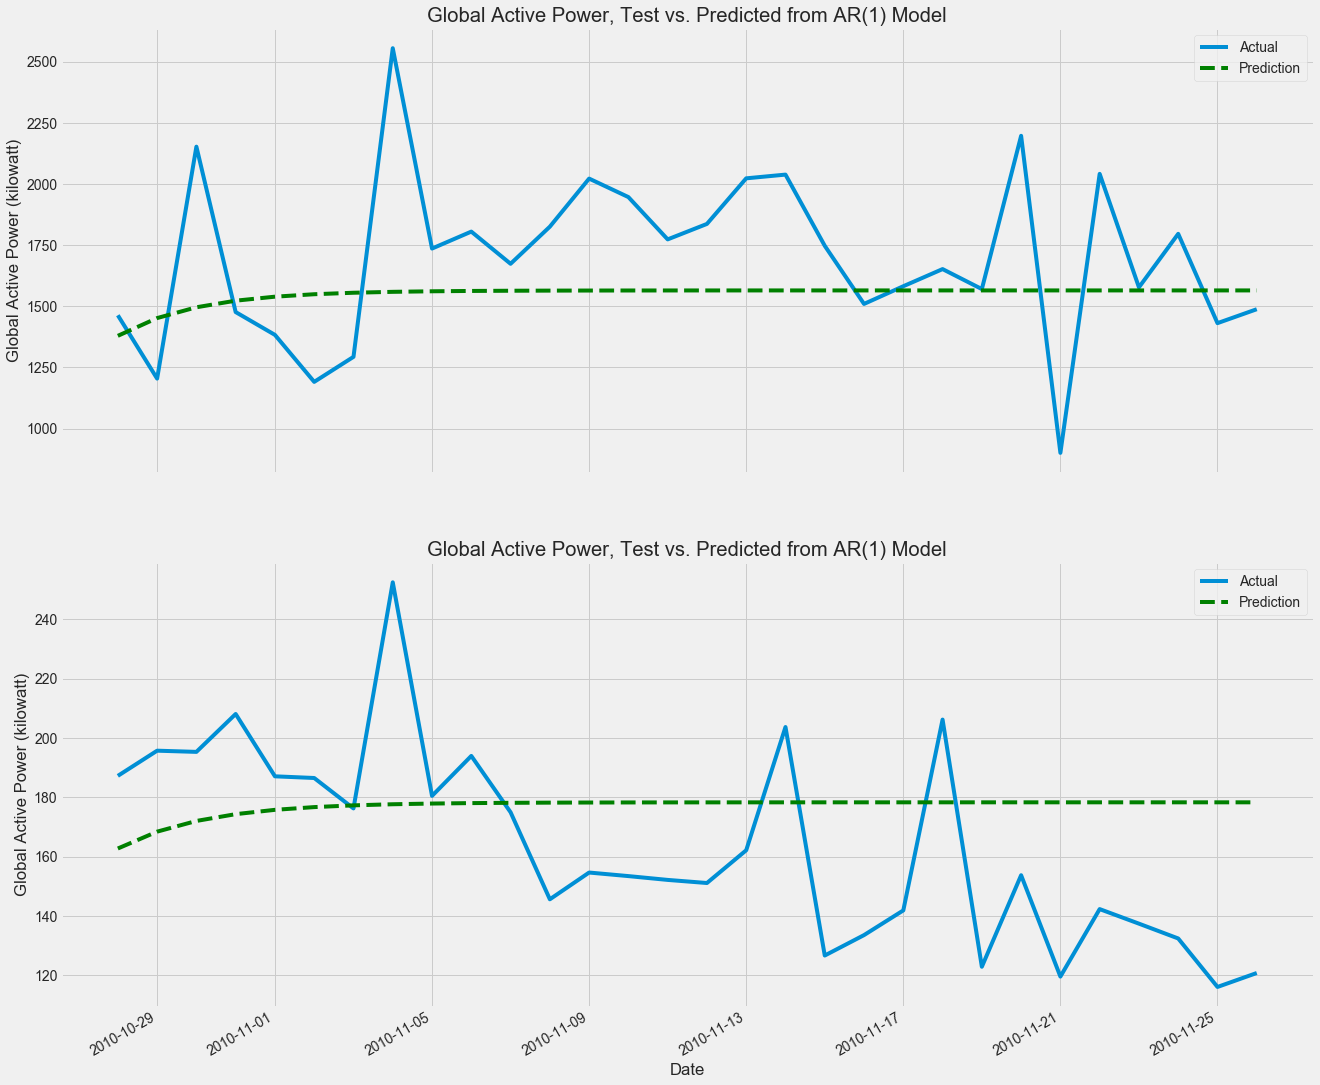

In [50]:
predict1 = pd.Series(data=p1.values,index=t1.index)
predict2 = pd.Series(data=p2.values,index=t2.index)
fig = plt.figure(figsize=(20,20)) 
    
ax1 = fig.add_subplot(211) 
ax1.plot(t1,label='Actual')
ax1.plot(predict1,color='green',linestyle='dashed',label='Prediction')
ax1.set_xlabel("Date") 
ax1.set_ylabel("Global Active Power (kilowatt)") 
ax1.grid(True)
ax1.set_title('Global Active Power, Test vs. Predicted from AR(1) Model') 
fig.autofmt_xdate()
ax1.legend()

ax2 = fig.add_subplot(212) 
ax2.plot(t2,label='Actual')
ax2.plot(predict2,color='green',linestyle='dashed',label='Prediction')
ax2.set_xlabel("Date") 
ax2.set_ylabel("Global Active Power (kilowatt)") 
ax2.grid(True)
ax2.set_title('Global Active Power, Test vs. Predicted from AR(1) Model') 
ax2.legend()
fig.autofmt_xdate()
plt.show()

The results of the test make sense. We're training the model on a large data set that has a lot of noise but that has a fairly consistent mean, so our prediction result is relatively flat, around the same levels you see in the training data. However, once this is compared to the 30 day test data set, we get a large RMSE because there is significant noise in the 30 day test set that our model hasn't picked up from the long term training set (where short term fluctuations cancel each other out). Overall, it may probably be a good approach if we want to understand the long term moving average, but it's not an effective model for predicting short term fluctuations or momentum.

In [51]:
import math
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error

In [52]:
n = 30 # number of Days

train = pwr_consumption.iloc[:len(pwr_consumption)-n].Global_active_power.values
test = pwr_consumption.iloc[len(pwr_consumption)-n:].Global_active_power.values
train_log, test_log = np.log10(train), np.log10(test)
model_order = (6, 0, 1)
model_seasonal_order = (0, 1, 1, 30)

#### Simple ARIMA 

predicted=3.128413, expected=3.165341
predicted=3.128596, expected=3.080779
predicted=3.127193, expected=3.332984
predicted=3.241589, expected=3.169213
predicted=3.141833, expected=3.140879
predicted=3.157094, expected=3.075942
predicted=3.144912, expected=3.111699
predicted=3.109610, expected=3.407416
predicted=3.276908, expected=3.239572
predicted=3.197291, expected=3.256575
predicted=3.247739, expected=3.223708
predicted=3.230466, expected=3.261391
predicted=3.212193, expected=3.305802
predicted=3.277046, expected=3.289262
predicted=3.260972, expected=3.248854
predicted=3.254116, expected=3.264067
predicted=3.255950, expected=3.306033
predicted=3.268707, expected=3.309288
predicted=3.276623, expected=3.242388
predicted=3.255556, expected=3.178904
predicted=3.222233, expected=3.199215
predicted=3.216697, expected=3.218050
predicted=3.213045, expected=3.196010
predicted=3.204740, expected=3.341831
predicted=3.275427, expected=2.954681
predicted=3.087020, expected=3.309957
predicted=3.

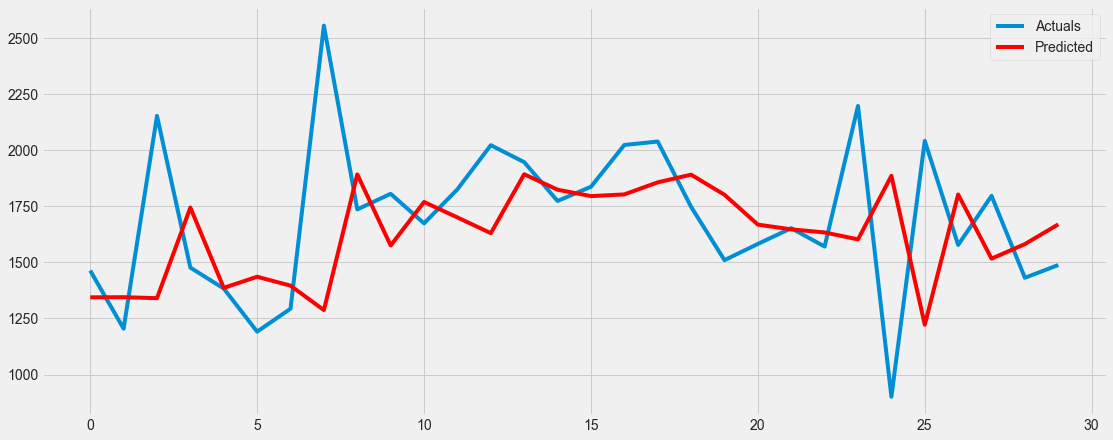

In [53]:
history = [x for x in train_log]
predictions = list()
predict_log=list()
for t in range(len(test_log)):
    model = sm.tsa.ARIMA(history, order=model_order)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    obs = test_log[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (output[0], obs))
error = math.sqrt(mean_squared_error(test_log, predict_log))
print('Test rmse: %.3f' % error)
# plot
figsize=(17, 7)
plt.figure(figsize=figsize)
plt.plot(test,label='Actuals')
plt.plot(predictions, color='red',label='Predicted')
plt.legend(loc='upper right')
plt.show()

## Simple SARIMA

predicted=3.127953, expected=3.165341
predicted=3.123868, expected=3.080779


/Users/carolynesalcido/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=3.119498, expected=3.332984
predicted=3.244913, expected=3.169213


/Users/carolynesalcido/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=3.167528, expected=3.140879


/Users/carolynesalcido/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=3.179606, expected=3.075942
predicted=3.148812, expected=3.111699
predicted=3.084780, expected=3.407416


/Users/carolynesalcido/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=3.259280, expected=3.239572
predicted=3.203886, expected=3.256575


/Users/carolynesalcido/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=3.242591, expected=3.223708
predicted=3.256728, expected=3.261391
predicted=3.186418, expected=3.305802
predicted=3.265576, expected=3.289262


/Users/carolynesalcido/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=3.244222, expected=3.248854


/Users/carolynesalcido/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=3.226689, expected=3.264067


/Users/carolynesalcido/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=3.258998, expected=3.306033
predicted=3.292777, expected=3.309288


/Users/carolynesalcido/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=3.271945, expected=3.242388
predicted=3.255293, expected=3.178904


/Users/carolynesalcido/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=3.214605, expected=3.199215
predicted=3.233097, expected=3.218050
predicted=3.243206, expected=3.196010
predicted=3.195361, expected=3.341831
predicted=3.275369, expected=2.954681
predicted=3.075157, expected=3.309957


/Users/carolynesalcido/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=3.270023, expected=3.197979


/Users/carolynesalcido/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=3.160775, expected=3.254366


/Users/carolynesalcido/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=3.207905, expected=3.155689


/Users/carolynesalcido/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=3.214893, expected=3.172633
Test rmse: 0.116


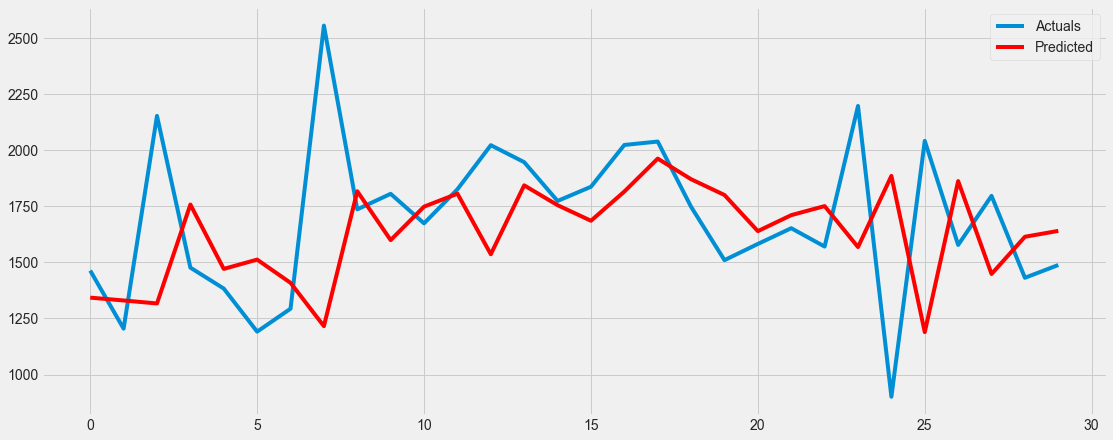

In [54]:
history = [x for x in train_log]
predictions = list()
predict_log=list()
for t in range(len(test_log)):
    model = sm.tsa.SARIMAX(history, order=model_order, seasonal_order=model_seasonal_order, enforce_stationarity=False,enforce_invertibility=False)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    obs = test_log[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (output[0], obs))
error = math.sqrt(mean_squared_error(test_log, predict_log))
print('Test rmse: %.3f' % error)
# plot
figsize=(17, 7)
plt.figure(figsize=figsize)
plt.plot(test,label='Actuals')
plt.plot(predictions, color='red',label='Predicted')
plt.legend(loc='upper right')
plt.show()

# Look for the trends and Seasonality and Residuals

Decompose the series (trend, seasonality, error) using statsmodels and seasonal_decompose

<Figure size 432x288 with 0 Axes>

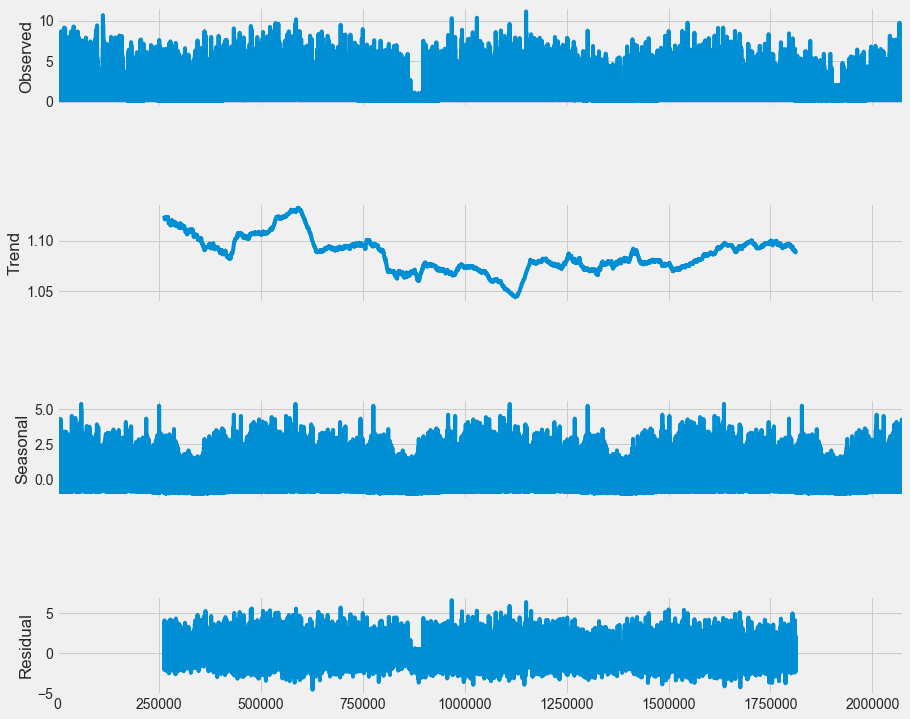

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Global_active_power'], model='additive', freq=int(24*60/1*365))
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

<Figure size 432x288 with 0 Axes>

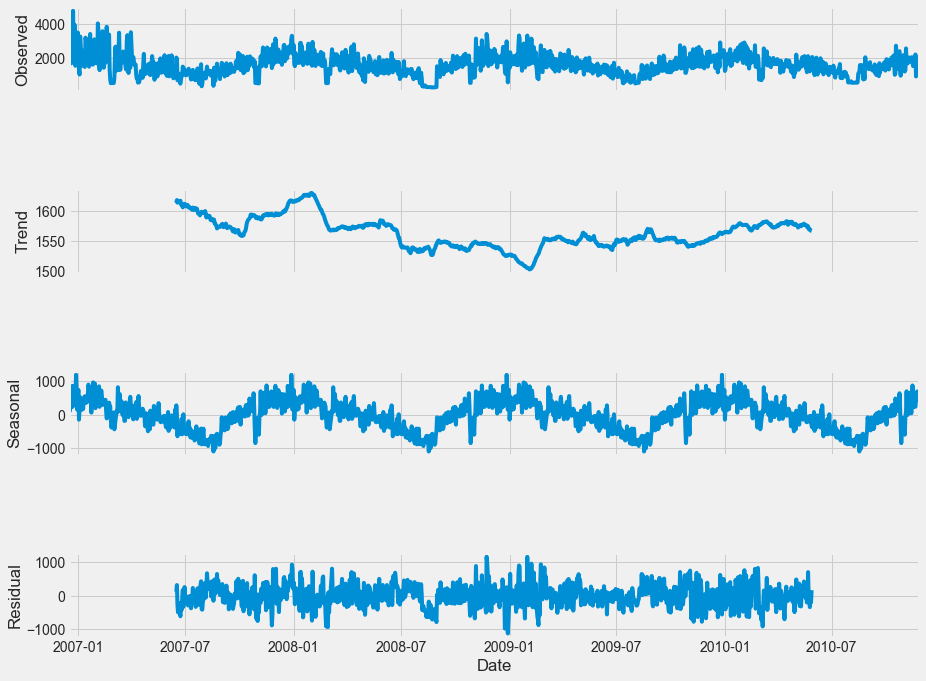

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(pwr_consumption['Global_active_power'], model='additive', freq=365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

- We observe a trend that increases and decreases over time
- The residual seems centered with a variance which seems constant
- The seasonality is noisy

## Dickey Fuller Test for Stationary/Non-Stationary Check

In [57]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(17, 7))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Dickey-Fuller Test Results:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    # maxlag et autolag
    dfoutput = pd.Series(dftest[0:4], index=['Statistical test' , 'p-value' , '#Lags used' , 'Number of observations used' ])
    for key,value in dftest[4].items():
        dfoutput['critical value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is presumably nonstationary.' % pvalue)
    
    print(dfoutput)

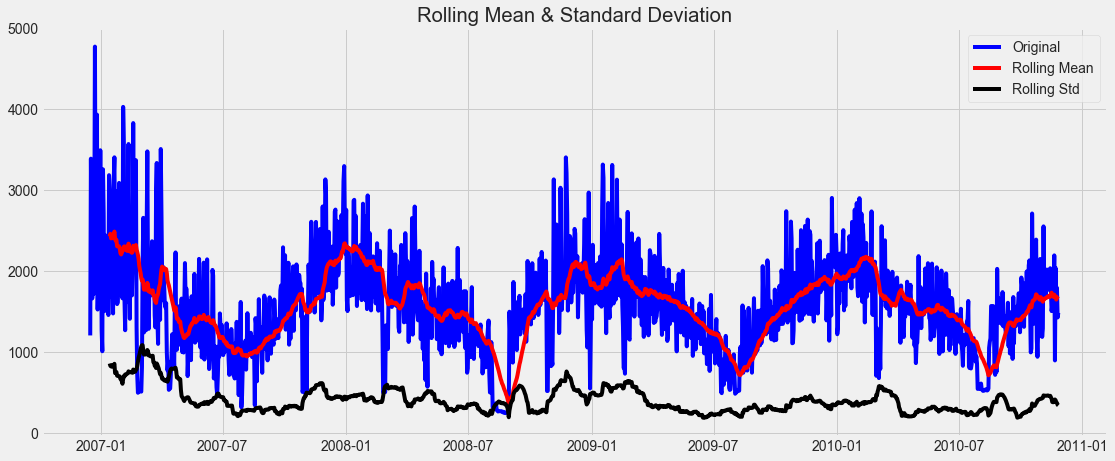

Dickey-Fuller Test Results:
p-value = 0.0063. The series is likely stationary.
Statistical test                 -3.573351
p-value                           0.006291
#Lags used                       20.000000
Number of observations used    1421.000000
critical value (1%)              -3.434960
critical value (5%)              -2.863576
critical value (10%)             -2.567854
dtype: float64


In [58]:
test_stationarity(pwr_consumption['Global_active_power'], 30) # Daily Data Summed

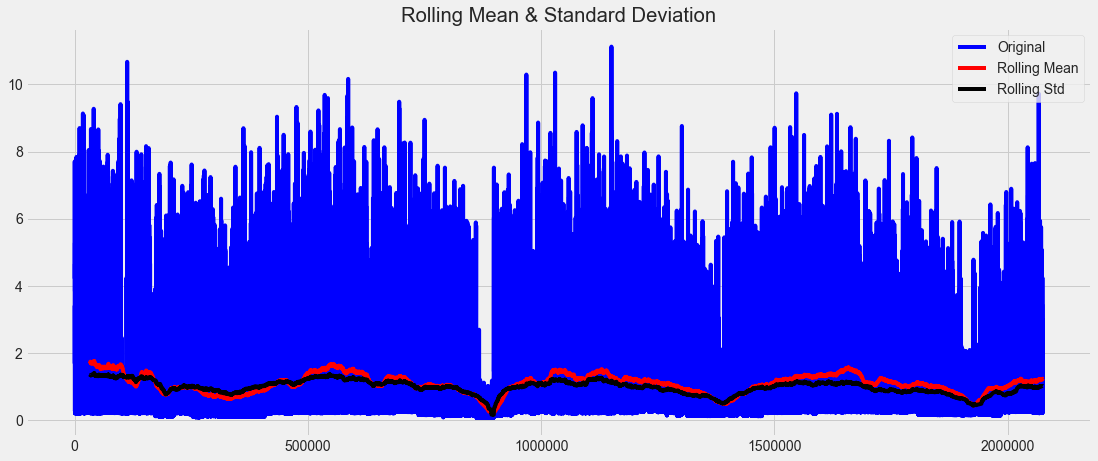

Dickey-Fuller Test Results:
p-value = 0.0000. The series is likely stationary.
Statistical test              -1.095151e+02
p-value                        0.000000e+00
#Lags used                     2.000000e+01
Number of observations used    2.075238e+06
critical value (1%)           -3.430353e+00
critical value (5%)           -2.861541e+00
critical value (10%)          -2.566771e+00
dtype: float64


In [59]:
test_stationarity(df['Global_active_power'], 30*1088) # Minute Data

and therefore we can initialize the value of d to 0 .

### ACF and PACF plots to get the AR and component for ARIMA and SARIMA

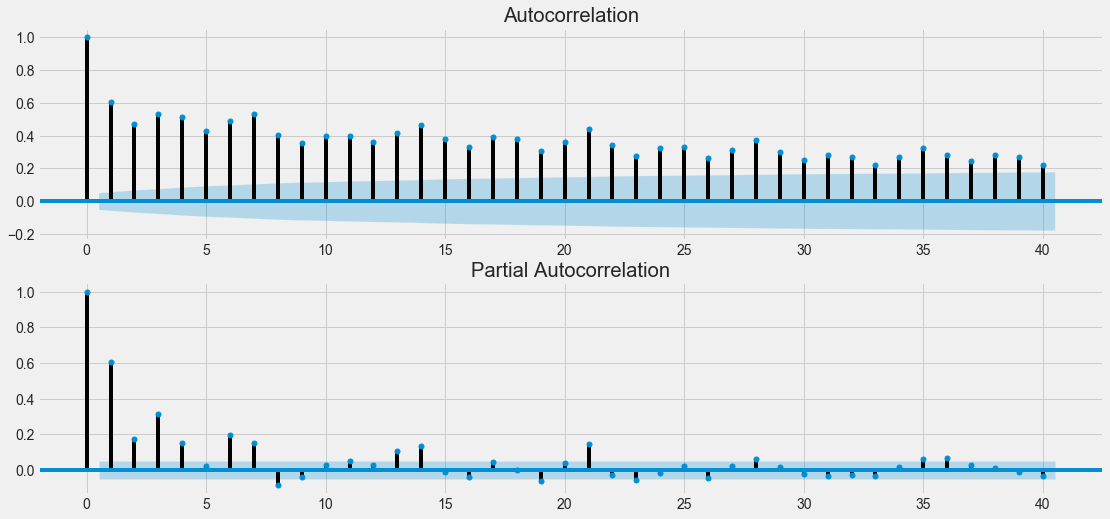

In [60]:
import statsmodels.api as sm

fig = plt.figure(figsize=(17,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(pwr_consumption.Global_active_power, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(pwr_consumption.Global_active_power, lags=40, ax=ax2)# , lags=40

The ACF remains quite strong

The PACF decreases and we then see a peak appear every 7 units.

∙ Calculation and display of ACF and PACF on the first order differentiate series

**Building the model How to determine p, d, q**

No order difference required
⇒ d = 0

- The AR model can be studied first with the length of the lag displayed by the PACF graph (or via empirical research). In our case, it is clear that an order 7 is a minimum. Which means we can use AR = 7

⇒ p = 7

⇒ q = 1


# ARIMA

/Users/carolynesalcido/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               ARMA Model Results                              
Dep. Variable:     Global_active_power   No. Observations:                 1442
Model:                      ARMA(6, 1)   Log Likelihood              -10784.306
Method:                        css-mle   S.D. of innovations            428.098
Date:                 Sun, 02 Aug 2020   AIC                          21586.613
Time:                         22:46:40   BIC                          21634.077
Sample:                     12-16-2006   HQIC                         21604.330
                          - 11-26-2010                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      1577.5665     83.205     18.960      0.000    1414.487    1740.646
ar.L1.Global_active_power     0.7275      0.085      8.599      0.000       0.

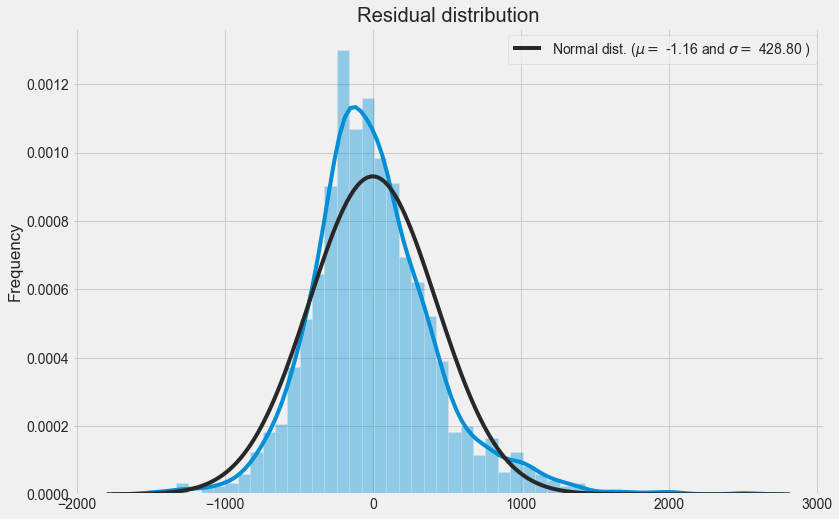

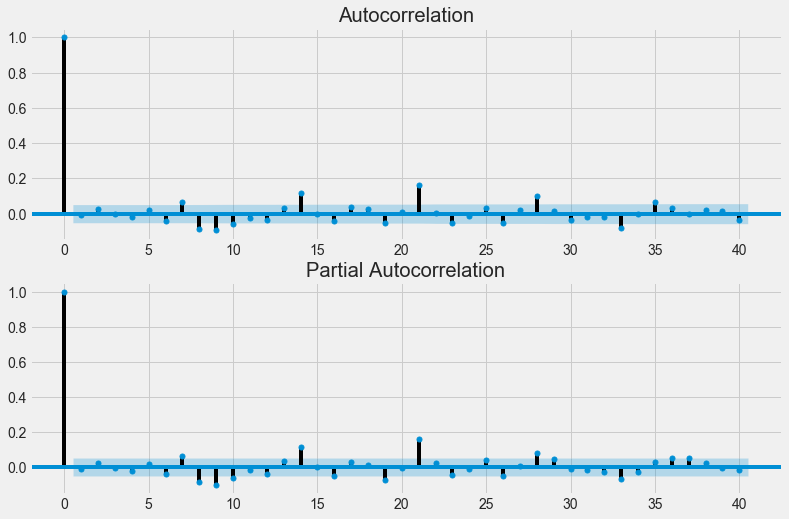

In [61]:
arima_mod = sm.tsa.ARIMA(pwr_consumption.Global_active_power, (6,0,1)).fit(disp=False)
print(arima_mod.summary())

# To see how our first model perform, we can plot the residual distribution. 
# See if it's normal dist. And the ACF and PACF. For a good model, we want to see the residual is normal distribution. 
# And ACF, PACF has not significant terms.

from scipy import stats
from scipy.stats import normaltest

resid = arima_mod.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod.resid, lags=40, ax=ax2)


Although the graph looks very like a normal distribution. But it failed the test. Also we see a recurring correlation exists in both ACF and PACF. So we need to deal with seasonality.

### ARIMA Predictions

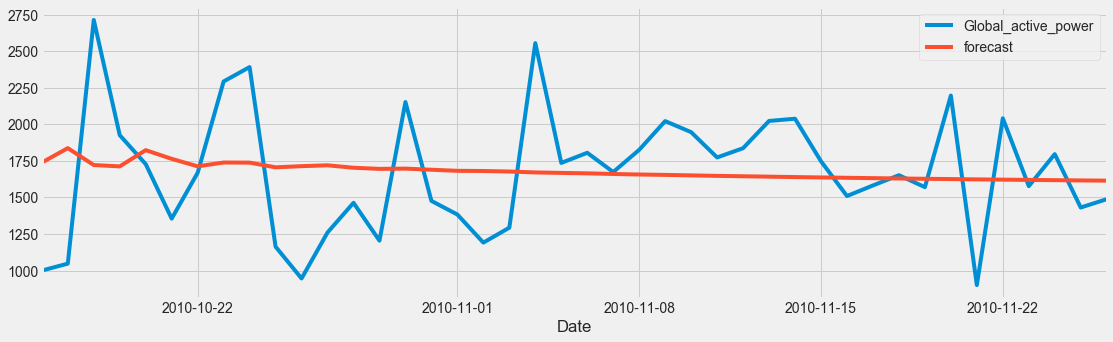

In [62]:
start_index = 1400
end_index = 1442
pwr_consumption['forecast'] = arima_mod.predict(start = start_index, end= end_index, dynamic= True)  
pwr_consumption[start_index:end_index][['Global_active_power', 'forecast']].plot(figsize=(17, 5))
plt.show()

In [63]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")
    
smape_kun(pwr_consumption[1400:1442]['Global_active_power'],pwr_consumption[1400:1442]['forecast'])

MAPE: 22.99 % 
SMAPE: 20.91 %


# SARIMA

/Users/carolynesalcido/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                            Statespace Model Results                           
Dep. Variable:     Global_active_power   No. Observations:                 1442
Model:                SARIMAX(6, 0, 1)   Log Likelihood              -10798.614
Date:                 Sun, 02 Aug 2020   AIC                          21613.228
Time:                         22:47:15   BIC                          21655.418
Sample:                     12-16-2006   HQIC                         21628.976
                          - 11-26-2010                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8312      0.065     12.874      0.000       0.705       0.958
ar.L2         -0.1823      0.038     -4.809      0.000      -0.257      -0.108
ar.L3          0.2055      0.029      7.156 

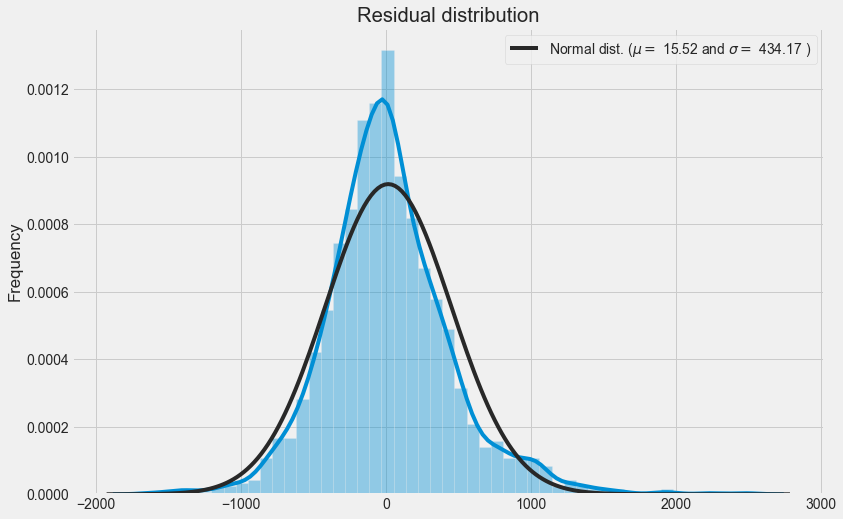

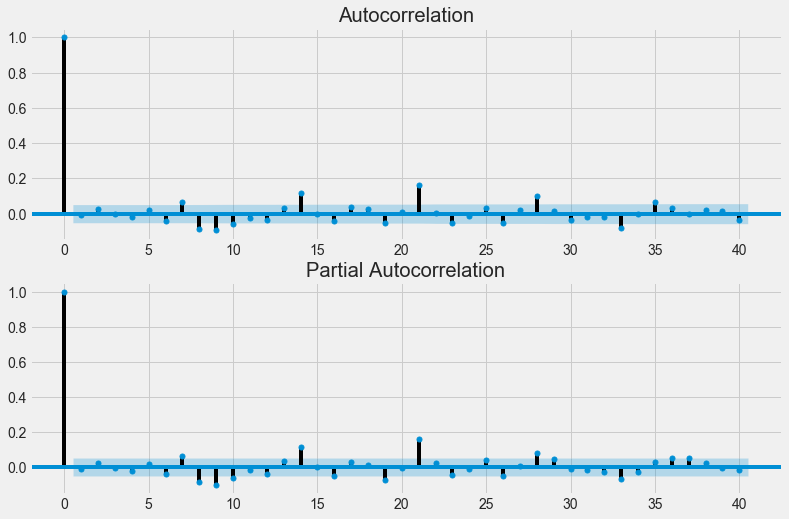

In [64]:
sarima_mod = sm.tsa.statespace.SARIMAX(pwr_consumption.Global_active_power, order=(6,0,1)).fit()
print(sarima_mod.summary())

resid = sarima_mod.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod.resid, lags=40, ax=ax2)

### SARIMA Predictions

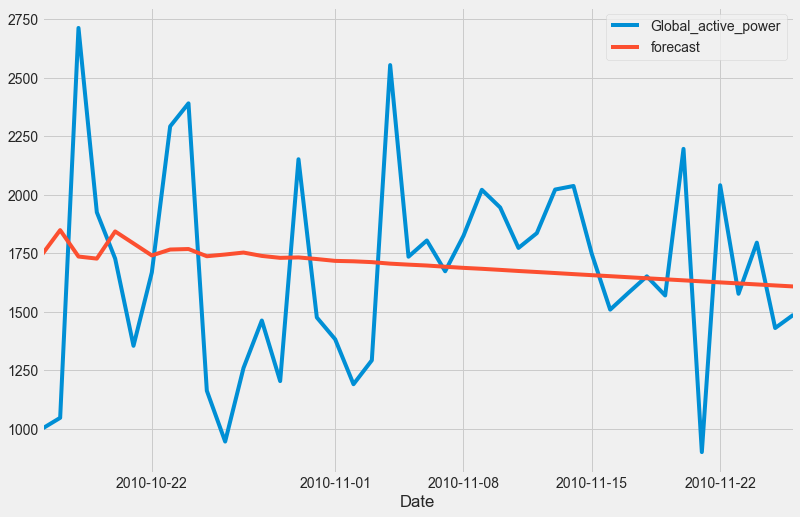

In [65]:
start_index = 1400
end_index = 1442
pwr_consumption['forecast'] = sarima_mod.predict(start = start_index, end= end_index, dynamic= True)  
pwr_consumption[start_index:end_index][['Global_active_power', 'forecast']].plot(figsize=(12, 8))

In [66]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")
    
smape_kun(pwr_consumption[1400:1442]['Global_active_power'],pwr_consumption[1400:1442]['forecast'])

MAPE: 23.28 % 
SMAPE: 20.88 %


##### Let's consider SARIMA and include the other features in the data, and add holidays data to build a more robust model

In [70]:
holiday = pd.read_csv('/Users/carolynesalcido/Downloads/usholidays.csv')
holiday['Date'] = pd.to_datetime(holiday['Date'])
holiday = holiday[['Date','Holiday']]
holiday.columns = ['date','holiday']
holiday.head()

,date,holiday
0,2010-12-31,New Year's Day
1,2011-01-17,"Birthday of Martin Luther King, Jr."
2,2011-02-21,Washington's Birthday
3,2011-05-30,Memorial Day
4,2011-07-04,Independence Day


In [71]:
pwr_consumption.head()

,Global_active_power,Global_reactive_power,forecast
Date,,,
2006-12-16,1209.176,34.922,NaN
2006-12-17,3390.460,226.006,NaN
2006-12-18,2203.826,161.792,NaN
2006-12-19,1666.194,150.942,NaN
2006-12-20,2225.748,160.998,NaN


In [72]:
pwr_consumption  = pwr_consumption.reset_index()
pwr_consumption.drop(['forecast'],axis = 1, inplace = True)
pwr_consumption.columns = ['date', 'Global_active_power', 'Global_reactive_power']

In [73]:
pwr_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Data columns (total 3 columns):
date                     1442 non-null object
Global_active_power      1442 non-null float64
Global_reactive_power    1442 non-null float64
dtypes: float64(2), object(1)
memory usage: 33.9+ KB


In [74]:
pwr_consumption['date'] = pd.to_datetime(pwr_consumption['date'])
train_df = pwr_consumption.merge(holiday, how='left', on='date')

train_df['holiday_bool'] = pd.notnull(train_df['holiday']).astype(int)

train_df['weekday'] = train_df['date'].dt.weekday
train_df['month'] = train_df['date'].dt.month

train_df = pd.get_dummies(train_df, columns = ['month','holiday','weekday'] , prefix = ['month','holiday','weekday'])

train_df.head()

,date,Global_active_power,Global_reactive_power,holiday_bool,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,"holiday_Martin Luther King, Jr. Day",holiday_Memorial Day,holiday_New Year’s Day,holiday_Thanksgiving Day,holiday_Veterans Day,holiday_Washington’s Birthday,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2006-12-16,1209.176,34.922,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2006-12-17,3390.460,226.006,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2006-12-18,2203.826,161.792,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2006-12-19,1666.194,150.942,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2006-12-20,2225.748,160.998,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [75]:
exog_data = train_df.drop(['Global_active_power', 'Global_reactive_power'], axis = 1)
exog_data = exog_data.set_index('date')
exog_data.head()

,holiday_bool,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,"holiday_Martin Luther King, Jr. Day",holiday_Memorial Day,holiday_New Year’s Day,holiday_Thanksgiving Day,holiday_Veterans Day,holiday_Washington’s Birthday,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-12-16,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2006-12-17,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2006-12-18,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2006-12-19,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2006-12-20,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [76]:
start_index = '2010-10-28'
end_index = '2010-11-26'

In [77]:

%%time

start_index = len(train_df)-30
end_index = len(train_df)

sarimax_mod6 = sm.tsa.statespace.SARIMAX(endog = train_df.Global_active_power.iloc[:start_index],
                                        exog = exog_data.iloc[:start_index].reset_index(drop = True),  
                                        trend='n', order=(7,0,1), seasonal_order=(0,1,1,7)).fit()
print(sarimax_mod6.summary())

                                 Statespace Model Results                                
Dep. Variable:               Global_active_power   No. Observations:                 1412
Model:             SARIMAX(7, 0, 1)x(0, 1, 1, 7)   Log Likelihood              -10435.610
Date:                           Sun, 02 Aug 2020   AIC                          20951.220
Time:                                   23:42:13   BIC                          21161.132
Sample:                                        0   HQIC                         21029.676
                                          - 1412                                         
Covariance Type:                             opg                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
holiday_bool                           45.7025     83.118      0.550    

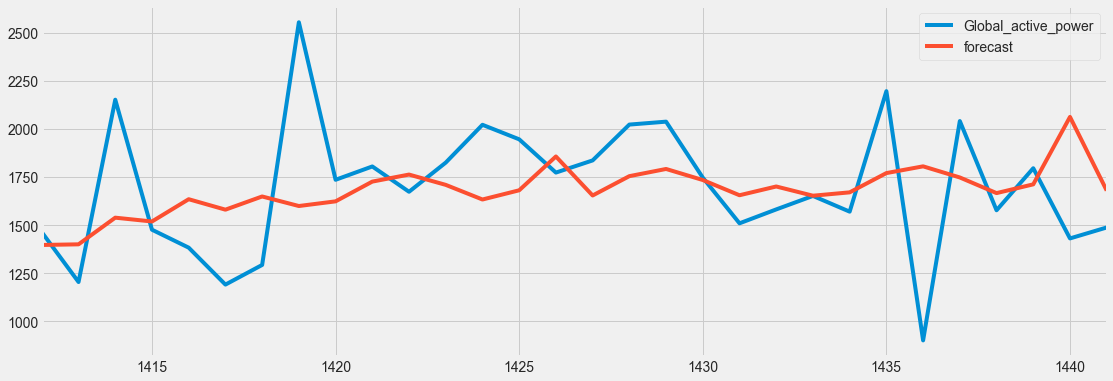

In [78]:
exog_data.index = train_df.index 
train_df['forecast'] = sarimax_mod6.predict(start = start_index, end= end_index-1,
                                            exog = exog_data[start_index:end_index], 
                                            dynamic= True)  

train_df[start_index:end_index][['Global_active_power', 'forecast']].plot(figsize=(17, 6))

In [79]:
smape_kun(train_df[start_index:end_index]['Global_active_power'],train_df[start_index:end_index]['forecast'])

MAPE: 16.31 % 
SMAPE: 15.25 %


The model has been better, Can we can expect it to be more accurate?